# Brain Tumor Classification with Pretrained Vision Transformer

In this project, we will be classifying different types of brain tumors using a deep learning model. We will specifically be using the Vision Transformer Model to classify these images.

In [3]:
!pip install tensorflow-addons
!pip install --quiet vit-keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from vit_keras import vit

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.5.0


In [5]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 7

TRAIN_PATH = '/content/drive/My Drive/Colab Notebooks/brain_tumor_mri/Training'
TEST_PATH = '/content/drive/My Drive/Colab Notebooks/brain_tumor_mri/Testing'

TEST_IMAGES = glob.glob(TEST_PATH + '/*.jpg')

classes = {0 : "Glioma Tumor",
           1 : "Meningioma Tumor",
           2 : "No Tumor",
           3 : "Pituitary Tumor"
           }

In [6]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          validation_split = 0.2,
                                                          preprocessing_function = vit.preprocess_inputs)

train_gen = datagen.flow_from_directory(directory = TRAIN_PATH,
                                        subset = 'training',
                                        batch_size = BATCH_SIZE,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = True,
                                        class_mode = 'categorical',
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE))

valid_gen = datagen.flow_from_directory(directory = TRAIN_PATH,
                                        subset = 'validation',
                                        batch_size = BATCH_SIZE,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = False,
                                        class_mode = 'categorical',
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE))

test_gen = datagen.flow_from_directory(directory = TEST_PATH, 
                                       batch_size = BATCH_SIZE,
                                       seed = 1,
                                       color_mode = 'rgb',
                                       shuffle = False,
                                       class_mode = None,
                                       target_size = (IMAGE_SIZE, IMAGE_SIZE))

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

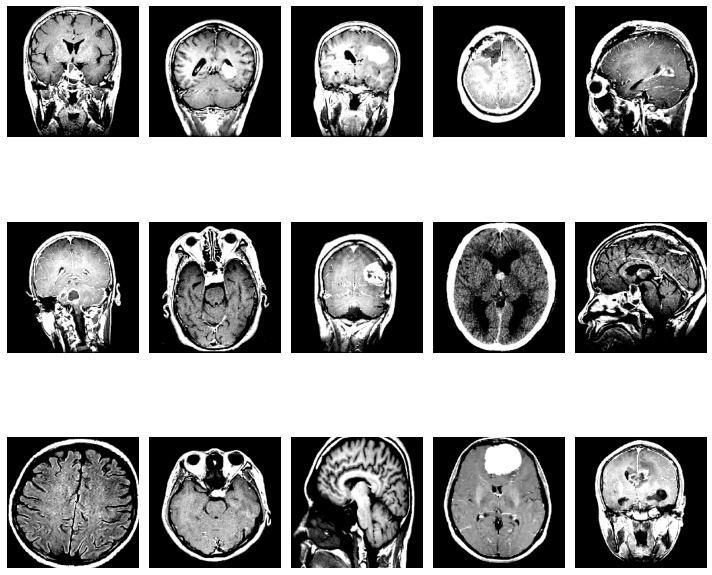

In [7]:
images = [train_gen[0][0][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE, 3))
    ax.axis('off')

plt.tight_layout()
plt.show()

## Vision Transformer

The vision transformer is a deep learning introduced in the paper ["An Image is worth 16x16 words: Transformers for Image Recognition at Scale"](https://arxiv.org/abs/2010.11929). It is a variation of the [Transformer](https://arxiv.org/abs/1706.03762) model, which is now widely popular as the state-of-the-art in various NLP tasks. The Vision Transformer model (ViT) is different from the architecture of Convolutional Neural Networks which have been the gold-standard for image classification tasks. 


In [8]:
vit_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 4)

353255424/353253686 [==============================] - 4s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


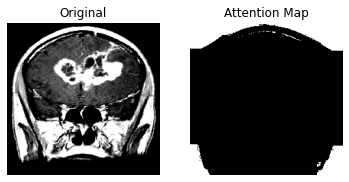

In [9]:
from vit_keras import visualize

x = test_gen.next()
image = x[0]

attention_map = visualize.attention_map(model = vit_model, image = image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols = 2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

In [10]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(4, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-b32 (Functional)         (None, 768)               87455232  
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 768)               3072      
_________________________________________________________________
dense (Dense)                (None, 11)                8459      
_________________________________________________________________
batch_normalization_1 (Batch (None, 11)                44        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 48        
Total params: 87,466,855
Trainable params: 87,465,297
Non-trainable params: 1,558
________________________________

In [11]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]

model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = callbacks)

model.save('model.h5')

Epoch 1/7
143/143 [==============================] - 1687s 11s/step - loss: 1.3519 - accuracy: 0.4958 - val_loss: 1.2071 - val_accuracy: 0.6089

Epoch 00001: val_accuracy improved from -inf to 0.60893, saving model to ./model.hdf5
Epoch 2/7
143/143 [==============================] - 1528s 11s/step - loss: 0.9656 - accuracy: 0.7707 - val_loss: 0.9904 - val_accuracy: 0.7750

Epoch 00002: val_accuracy improved from 0.60893 to 0.77500, saving model to ./model.hdf5
Epoch 3/7
143/143 [==============================] - 1531s 11s/step - loss: 0.8512 - accuracy: 0.8676 - val_loss: 0.9322 - val_accuracy: 0.7875

Epoch 00003: val_accuracy improved from 0.77500 to 0.78750, saving model to ./model.hdf5
Epoch 4/7
143/143 [==============================] - 1535s 11s/step - loss: 0.7775 - accuracy: 0.9171 - val_loss: 0.8486 - val_accuracy: 0.8750

Epoch 00004: val_accuracy improved from 0.78750 to 0.87500, saving model to ./model.hdf5
Epoch 5/7
143/143 [==============================] - 1534s 11s/step

TypeError: ignored

              precision    recall  f1-score   support

           0       0.97      0.87      0.92       165
           1       0.88      0.73      0.80       164
           2       0.95      0.94      0.94        79
           3       0.75      0.96      0.84       165

    accuracy                           0.86       573
   macro avg       0.89      0.87      0.87       573
weighted avg       0.88      0.86      0.86       573



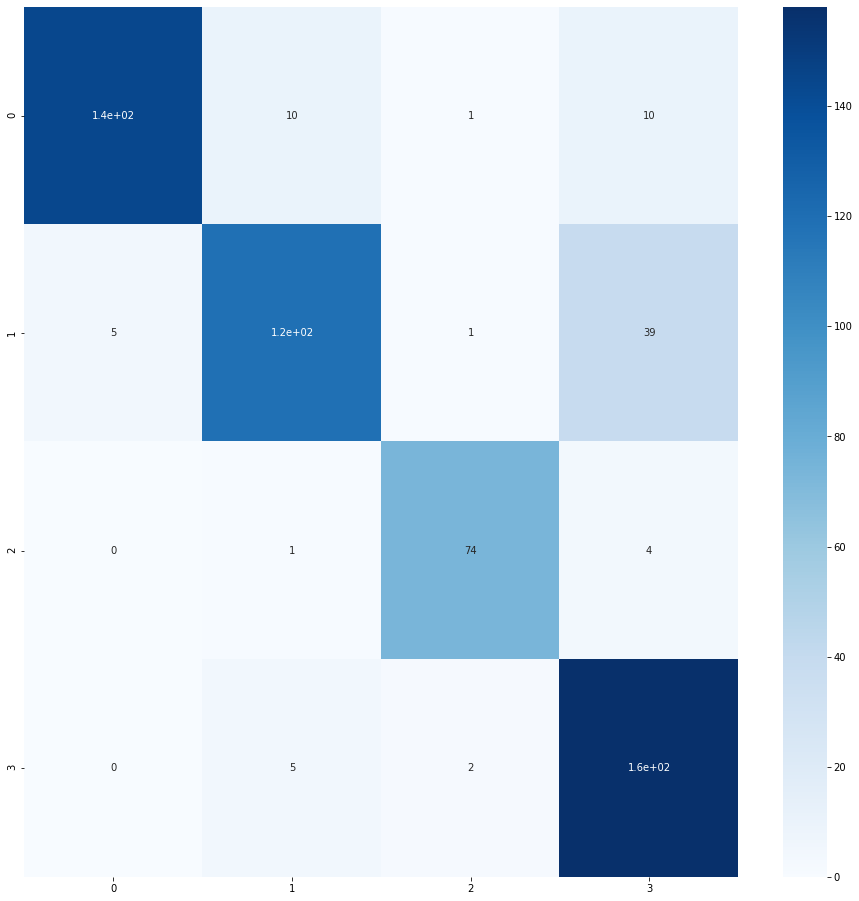

In [12]:
predicted_classes = np.argmax(model.predict(valid_gen, steps = valid_gen.n // valid_gen.batch_size + 1), axis = 1)
true_classes = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys())  

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))